# Analyze Cascade
Load cascade state obtained from Julia and use Qutip to track relevant metrics

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qutip import Qobj
import qutip as qt

from pathlib import Path
import tomli

CS1 = "#454545"
CS2 = "#888888"

In [2]:
# ROOT = Path("./simulations/simulation_420f7f85-5")
ROOT = Path("./simulations/simulation_050df8a8-2")
# ROOT = Path("./simulations/simulation_9b166bbe-b")
# Create visualization folder
OUTPUT = ROOT / "visualization"
OUTPUT.mkdir(parents=True, exist_ok=True)
with open(ROOT / "config.toml", "rb") as f:
    config = tomli.load(f)

NDIMS = int(config["meta"]["dims"])
dt = config["meta"]["dt"]
alpha = config["cavity1"]["alpha"]

isochore_steps = config["stroke_time"]["isochore"]
isochore_samplings = config["samplings"]["isochore"]
adiabatic_samplings = config["samplings"]["adiabatic"]

system_evolution = np.load(ROOT / "cascade_evolution_1cycle.npz")
cavities_evolution = np.load(ROOT / "cavities_evolution_1cycle.npz")

cycle_steps = np.load(ROOT / "cycle_steps.npy")  # Duration of each step 
# cycle_steps = np.diff(np.load(ROOT / "cycle_steps.npy"), prepend=0)

samplings = sorted(system_evolution.files, key=lambda x: int(x))

# Take the left-hand side of each interval
strokes = [
    (0, cycle_steps[0]),
    (cycle_steps[0] + dt, cycle_steps[1]),
    (cycle_steps[1] + dt, cycle_steps[2]),
    (cycle_steps[2] + dt, cycle_steps[3]),
]
# Take the left-hand side of each interval
sampling_times = np.array([
    *np.linspace(*strokes[0], isochore_samplings),
    *np.linspace(*strokes[1], adiabatic_samplings),
    *np.linspace(*strokes[2], isochore_samplings),
    *np.linspace(*strokes[3], adiabatic_samplings)
]).flatten()


# sampling_times_dict = {v: k for k, v in zip(samplings, sampling_times)}

len(samplings)
print(cycle_steps)

[150.   158.45 308.45 315.16]


In [3]:
strokes

[(0, 150.0),
 (150.01, 158.44999999999987),
 (158.45999999999987, 308.4499999999999),
 (308.45999999999987, 315.1599999999998)]

In [4]:
def avg_energy(s:Qobj, h:Qobj) -> float:

    return (s * h).tr()


def plot_observable(x, y, ymin=None, ymax=None, label=None, ax=None, title=None, grid=False):
    if not ax:
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(title)

        if grid:
            ax.grid(linestyle="--", alpha=0.2)
        
        if not ymin:
            ymin = min(y) - 0.2*min(y) if min(y) > 0 else min(y) + 0.2*min(y)
        ymax = max(y) + 0.2*max(y) if not ymax else ymax
        plot_stroke_overlays(ax, ymin, ymax)

    ax.plot(x, y, label=label)
    if label:
        ax.legend()
        
    return ax


def plot_stroke_overlays(ax, ymin, ymax):
    ax.fill_betweenx([ymin, ymax], *strokes[0], alpha=0.1, fc='r')
    ax.fill_betweenx([ymin, ymax], *strokes[2], alpha=0.1, fc='b')

In [5]:
c1_lenghts = [alpha / f for f in cavities_evolution["c1"]]
c2_lenghts = [alpha / f for f in cavities_evolution["c2"]]
energy = []
energy1 = []
energy2 = []
entropy = []
entropy1 = []
entropy2 = []
mutinf = []
concurrence = []

dims = NDIMS
s_evolution = []
s1_evolution = []
s2_evolution = []
h_evolution = []

for timestep in samplings:
    s_evolution.append(
        Qobj(system_evolution[timestep], dims=[[dims,dims], [dims,dims]]))

for t, rho in enumerate(s_evolution):
    s1:Qobj = rho.ptrace(0)
    s2:Qobj = rho.ptrace(1)
    s1_evolution.append(s1)
    s2_evolution.append(s2)

    f1:float = cavities_evolution["c1"][t]
    f2:float = cavities_evolution["c2"][t]
    # Hamiltonian
    h1 = Qobj(f1 * np.diag(np.arange(1, dims + 1)))
    h2 = Qobj(f2 * np.diag(np.arange(1, dims + 1)))
    h = qt.tensor(h1, h2)
    h_evolution.append(h)
    
    # Observables
    energy.append(avg_energy(rho, h))
    energy1.append(avg_energy(s1, h1))
    energy2.append(avg_energy(s2, h2))
    entropy.append(qt.entropy_vn(rho))
    entropy1.append(qt.entropy_vn(s1))
    entropy2.append(qt.entropy_vn(s2))
    mutinf.append(qt.entropy_mutual(rho, 0, 1))

    if t % 50 == 0:
        print(f"Timestep {t}")


Timestep 0
Timestep 50
Timestep 100
Timestep 150
Timestep 200
Timestep 250


## Cycles

Text(0.5, 1.0, 'Movement of the cavities')

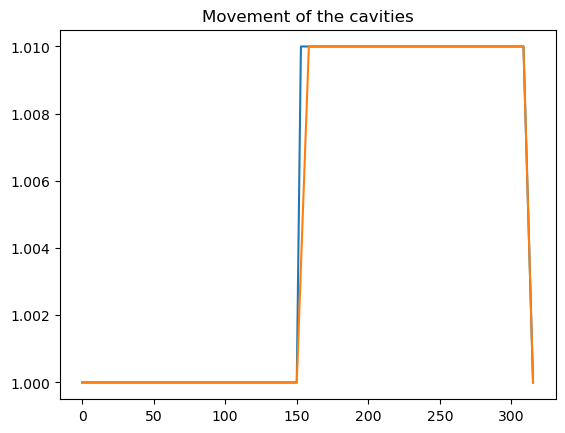

In [6]:
plt.plot(sampling_times, c1_lenghts)
plt.plot(sampling_times, c2_lenghts)
plt.title("Movement of the cavities")

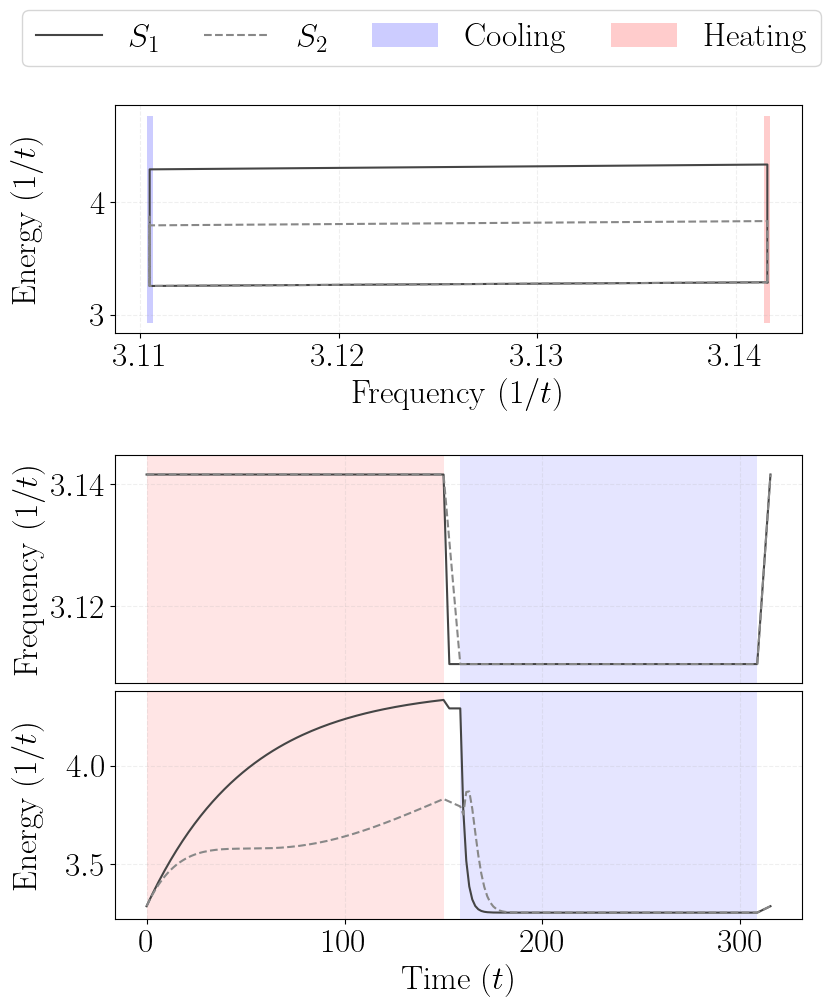

In [9]:
plt.rcParams.update({'text.usetex': True, 'font.family': 'serif', 'font.size': 24})

f1 = cavities_evolution["c1"]
f2 = cavities_evolution["c2"]

fig = plt.figure(layout="constrained", figsize=(8, 9))
gs = fig.add_gridspec(3, 1)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0], sharex=ax2)
# fig.suptitle("Cavities Cycles")
ax1.plot(f1, energy1, label="$S_1$", c=CS1)
ax1.plot(f2, energy2, label="$S_2$", c=CS2, ls="--")
ax1.set_ylabel("Energy $(1/t)$", labelpad=34)
ax1.set_xlabel("Frequency $(1/t)$")
# ax1.text(0.495, 0.49, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS2,
#      verticalalignment='center', transform=ax1.transAxes, fontsize=60)
# ax1.text(0.505, 0.51, u'\u27f2', horizontalalignment='center', alpha=0.1, color=CS1,
#      verticalalignment='center', transform=ax1.transAxes, fontsize=60)

ymax = max(max(energy1), max(energy2)) + 0.1*max(max(energy1), max(energy2))
ymin = min(min(energy1), min(energy2)) - 0.1*min(min(energy1), min(energy2))
# Heating stroke at maximum frequency
x_heating = max(max(f1), max(f2))
dx_h = 0.00005 * x_heating
# Cooling stroke at minimum frequency
x_cooling = min(min(f1), min(f2))
dx_c = 0.00005 * x_cooling
ax1.fill_between([x_cooling - dx_c, x_cooling + dx_c], ymin, ymax, alpha=0.2, fc='b', label="Cooling")
ax1.fill_between([x_heating - dx_h, x_heating + dx_h], ymin, ymax, alpha=0.2, fc='r', label="Heating")

ax2.set_ylabel("Frequency $(1/t)$")
ymin = min(min(f1), min(f2)) - 0.001*min(min(f1), min(f2))
ymax = max(max(f1), max(f2)) + 0.001*max(max(f1), max(f2))
ax2.plot(sampling_times, f1, c=CS1)
ax2.plot(sampling_times, f2, c=CS2, ls="--")
ax2.fill_between([*strokes[0]], ymin, ymax, alpha=0.1, fc='r')
ax2.fill_between([*strokes[2]], ymin, ymax, alpha=0.1, fc='b')
ax2.set_ylim(ymin, ymax)

ax2.set_title("%")
ax3.set_ylabel("Energy $(1/t)$", labelpad=16)
ymin = min(min(energy1), min(energy2)) - 0.01*min(min(energy1), min(energy2))
ymax = max(max(energy1), max(energy2)) + 0.01*max(max(energy1), max(energy2))
ax3.plot(sampling_times, energy1, c=CS1)
ax3.plot(sampling_times, energy2, c=CS2, ls="--")
ax3.fill_between([*strokes[0]], ymin, ymax, alpha=0.1, fc='r')
ax3.fill_between([*strokes[2]], ymin, ymax, alpha=0.1, fc='b')
ax3.set_ylim(ymin, ymax)
# Hide x-axis labels and ticks on ax2
ax2.tick_params(labelbottom=False, bottom=False)
ax2.set_xlabel('')
ax3.set_xlabel('Time $(t)$')
fig.legend(bbox_to_anchor=(0., 1., 1.04, 0.12), loc=2, ncol=4, mode="expand", prop={'size': 24})

for ax in (ax1, ax2, ax3):
    ax.grid(alpha=0.2, linestyle='--')  

plt.savefig(OUTPUT / "cycle_dynamics.png", bbox_inches='tight', dpi=300)
plt.savefig(OUTPUT / "cycle_dynamics.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [129]:
np.pi/config["phaseonium"]["phi_hot"] == np.pi*(1/config["phaseonium"]["phi_hot"])

True

In [130]:
print(config["phaseonium"]["phi_cold"])
print(1/config["phaseonium"]["phi_hot"])

40.0
0.8474576271186441


## Entropy

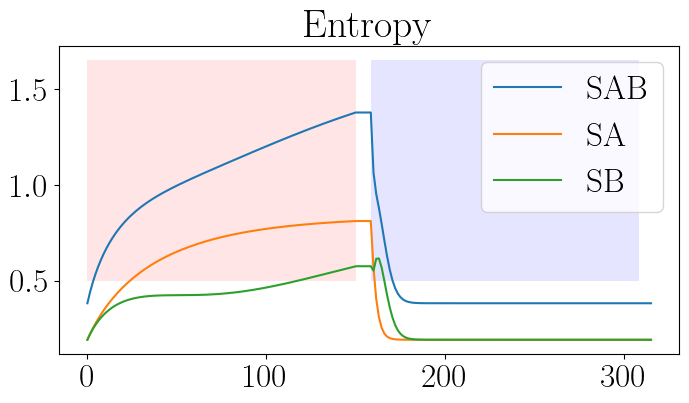

In [131]:
ax = plot_observable(sampling_times, entropy, label="SAB", ymin=0.5)
plot_observable(sampling_times, entropy1, label="SA", ax=ax)
plot_observable(sampling_times, entropy2, label="SB", ax=ax)

ax.set_title("Entropy")

plt.savefig(OUTPUT / "entropy.png")
plt.savefig(OUTPUT / "entropy.pdf")

## Mutual Information

In [132]:
working_time1 = np.argwhere([strokes[1][0] < s < strokes[1][1] for s in sampling_times])
np.array(mutinf)[working_time1].mean()

0.007923611623836369

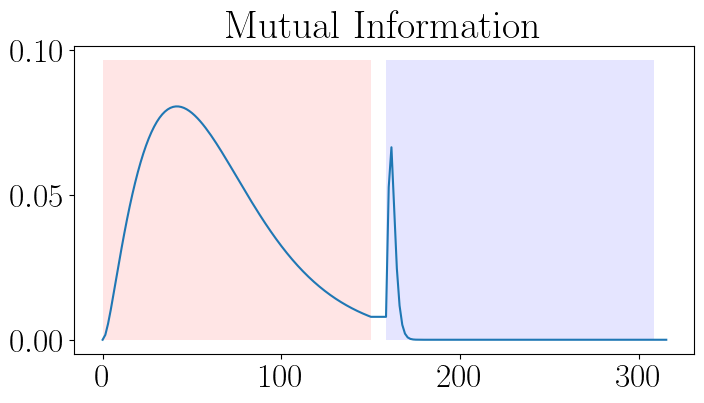

In [133]:
ax = plot_observable(sampling_times, mutinf)
ax.set_title("Mutual Information")

plt.savefig(OUTPUT / "mutual_information.png")
plt.savefig(OUTPUT / "mutual_information.pdf")

## Alicki's Definition of Heat and Work

$$
\begin{align}
W &= - \int\text{Tr}\left[ \dot{H}(t)\rho(t) \right]dt \\
Q &=   \int\text{Tr}\left[ H(t)\dot{\rho}(t) \right]dt \\
\end{align}
$$

In [24]:
# Calculate work and heat by Alicki's definition
def alickis_definition(rho_list, hamiltonian_list, energy_list):
    
    # Energy changes between steps
    delta_energy = np.diff(energy_list)
    
    # Calculate adiabatic energy changes (work)
    # This requires calculating energy expectation of previous density matrix with current Hamiltonian
    work_contributions = []
    for i in range(1, len(rho_list)):
        # Energy the system would have had with previous state but current Hamiltonian
        adiabatic_energy = qt.expect(hamiltonian_list[i], rho_list[i-1])
        # Energy it had at previous step
        previous_energy = energy_list[i-1]
        # Work is the energy change due to Hamiltonian change
        work_contribution = adiabatic_energy - previous_energy
        work_contributions.append(work_contribution)
    
    work = np.array(work_contributions)
    
    # Heat is the remaining energy change
    heat = delta_energy - work
    
    total_work = np.sum(work)
    total_heat = np.sum(heat)
    
    return total_work, total_heat, work, heat


def calc_pressure_op(ndims, alpha, l, s, t):
    idd = Qobj(np.diag(np.ones(ndims)))  # Identity matrix
    n = Qobj(np.diag(np.arange(1, ndims + 1)))
    a = qt.destroy(ndims)
    ad = a.dag()

    f = alpha / l

    pressure_op = (2*n + idd)
    pressure_op -= (a * a * np.exp(-1j*2*f*t)) 
    pressure_op -= (ad * ad * np.exp(1j*2*f*t))

    return alpha*f / (2 * l**2 * s) * pressure_op


def pressure_work(rho_list, position_list, sampling_times, alpha, s):

    delta_l = np.diff(position_list)

    work_contributions = []
    # Calculate the pressure operator for one cavity
    for i, t in enumerate(sampling_times[1:]):
        l = position_list[i+1]
        pressure_op = calc_pressure_op(NDIMS, alpha, l, s, t)

        pressure = qt.expect(pressure_op, rho_list[i+1])

        work_contribution = pressure * s * delta_l[i]
        work_contributions.append(work_contribution)

    work = - np.array(work_contributions)
    total_work = np.sum(work)

    return total_work, work


# Compute work via the external force applied to the moving mirror
def classical_work(force_list, position_list):
    # Calculate the movement of the cavity
    delta_l = np.diff(position_list)

    work_contributions = []
    for i in range(1, len(force_list)):
        work_contribution = force_list[i] * delta_l[i-1]
        work_contributions.append(work_contribution) 

    work = - np.array(work_contributions)
    total_work = np.sum(work)

    return total_work, work

### Heat

Total Heat: 0.13446999743688615
Absorbed Heat: 6.824519621639684


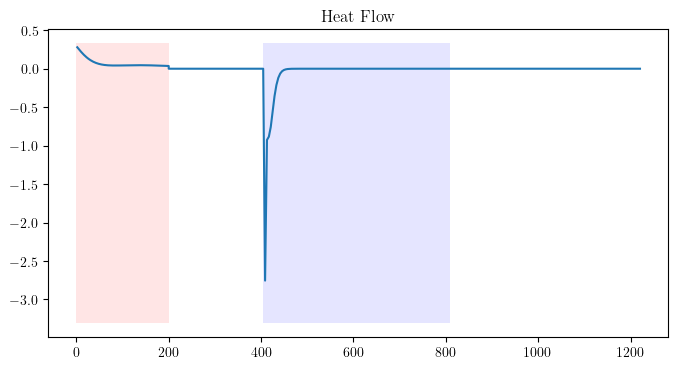

In [25]:
# Calculate total heat by Alicki's definition
_, total_heat, _, heat = alickis_definition(s_evolution, h_evolution, energy)
absorbed_heat = np.sum(np.real(heat[heat > 0]))

ax = plot_observable(sampling_times[1:], np.real(heat))
ax.set_title("Heat Flow")

print(f"Total Heat: {np.real(total_heat)}")
print(f"Absorbed Heat: {absorbed_heat}")

plt.savefig(OUTPUT / "heat.png")
plt.savefig(OUTPUT / "heat.pdf")

### Work

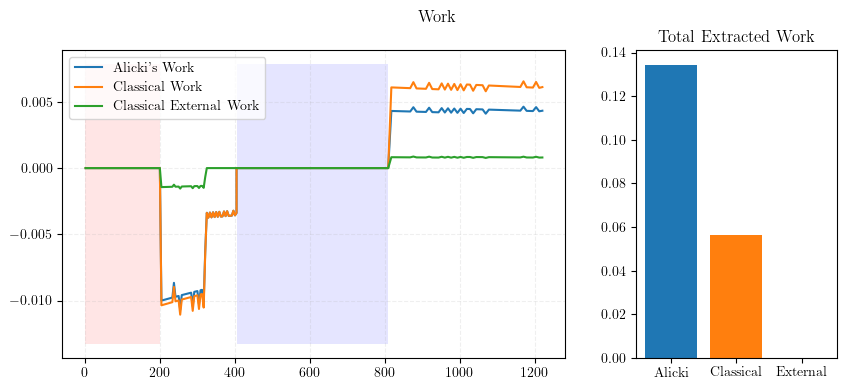

In [26]:
# Calculate total work by Alicki's definition
total_work_al, _, work_al, _ = alickis_definition(s_evolution, h_evolution, energy)
total_work_al = np.real(total_work_al)
work_al = np.real(work_al)

# Calculate work through classical mechanics
total_work_ext = 0
works_ext = []
for i, cavity_l in enumerate([c1_lenghts, c2_lenghts]):
    cavity_config = config[f"cavity{i + 1}"]
    force_evolution = [0 for _ in range(isochore_samplings)]
    force_evolution += [cavity_config["expanding_force"] for _ in range(adiabatic_samplings)]
    force_evolution += [0 for _ in range(isochore_samplings)]
    force_evolution += [cavity_config["compressing_force"] for _ in range(adiabatic_samplings)]
    _total_work, _work = classical_work(force_evolution, c1_lenghts)
    total_work_ext += np.real(_total_work)
    works_ext.append(np.real(_work))

total_work = 0
works = []
for i, (s_list, l_list) in enumerate(zip([s1_evolution, s2_evolution], [c1_lenghts, c2_lenghts])):
    cavity_config = config[f"cavity{i + 1}"]
    alpha = cavity_config["alpha"]
    s = cavity_config["surface"]

    _total_work, _work = pressure_work(s_list, l_list, sampling_times, alpha, s)
    total_work += np.real(_total_work)
    works.append(np.real(_work))

fig, (ax, axbar) = plt.subplots(1, 2, figsize=(10, 4), width_ratios=[5, 2])
fig.suptitle("Work")
ax.grid(alpha=0.2, linestyle='--')

ymax = max([
    max(work_al), max(works[0] + works[1]), max(works_ext[0] + works_ext[1])])
ymin = min([
    min(work_al), min(works[0] + works[1]), min(works_ext[0] + works_ext[1])])

plot_stroke_overlays(ax, ymin + 0.2*ymin, ymax + 0.2*ymax)

plot_observable(sampling_times[1:], np.real(work_al), ax=ax, label="Alicki's Work")
plot_observable(sampling_times[1:], works[0] + works[1], ax=ax, label="Classical Work")
# plot_observable(sampling_times[1:], works[0], ax=ax, label="Classical Work S1")
# plot_observable(sampling_times[1:], works[1], ax=ax, label="Classical Work S2")
plot_observable(sampling_times[1:], works_ext[0] + works_ext[1], ax=ax, label="Classical External Work")
# plot_observable(sampling_times[1:], works_ext[0], ax=ax, label="Classical External Work S1")
# plot_observable(sampling_times[1:], works_ext[1], ax=ax, label="Classical External Work S2")
ax.legend()

axbar.bar(["Alicki", "Classical", "External"], 
          [-total_work_al, -total_work, abs(total_work_ext)],
          color=["tab:blue", "tab:orange", "tab:green"])
axbar.set_title("Total Extracted Work")

plt.savefig(OUTPUT / "work.png")
plt.savefig(OUTPUT / "work.pdf")

plt.show()

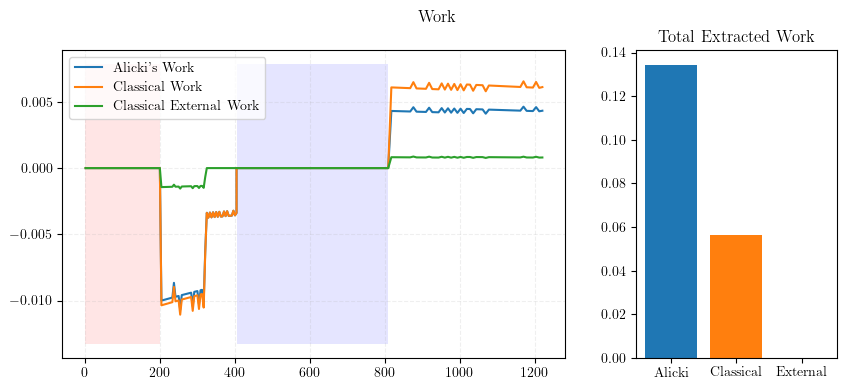

In [28]:
# Calculate total work by Alicki's definition
total_work_al, _, work_al, _ = alickis_definition(s_evolution, h_evolution, energy)
total_work_al = np.real(total_work_al)
work_al = np.real(work_al)

# Calculate work through classical mechanics
total_work_ext = 0
works_ext = []
for i, cavity_l in enumerate([c1_lenghts, c2_lenghts]):
    cavity_config = config[f"cavity{i + 1}"]
    force_evolution = [0 for _ in range(isochore_samplings)]
    force_evolution += [cavity_config["expanding_force"] for _ in range(adiabatic_samplings)]
    force_evolution += [0 for _ in range(isochore_samplings)]
    force_evolution += [cavity_config["compressing_force"] for _ in range(adiabatic_samplings)]
    _total_work, _work = classical_work(force_evolution, c1_lenghts)
    total_work_ext += np.real(_total_work)
    works_ext.append(np.real(_work))

total_work = 0
works = []
for i, (s_list, l_list) in enumerate(zip([s1_evolution, s2_evolution], [c1_lenghts, c2_lenghts])):
    cavity_config = config[f"cavity{i + 1}"]
    alpha = cavity_config["alpha"]
    s = cavity_config["surface"]

    _total_work, _work = pressure_work(s_list, l_list, sampling_times, alpha, s)
    total_work += np.real(_total_work)
    works.append(np.real(_work))

fig, (ax, axbar) = plt.subplots(1, 2, figsize=(10, 4), width_ratios=[5, 2])
fig.suptitle("Work")
ax.grid(alpha=0.2, linestyle='--')

ymax = max([
    max(work_al), max(works[0] + works[1]), max(works_ext[0] + works_ext[1])])
ymin = min([
    min(work_al), min(works[0] + works[1]), min(works_ext[0] + works_ext[1])])

plot_stroke_overlays(ax, ymin + 0.2*ymin, ymax + 0.2*ymax)

plot_observable(sampling_times[1:], np.real(work_al), ax=ax, label="Alicki's Work")
plot_observable(sampling_times[1:], works[0] + works[1], ax=ax, label="Classical Work")
# plot_observable(sampling_times[1:], works[0], ax=ax, label="Classical Work S1")
# plot_observable(sampling_times[1:], works[1], ax=ax, label="Classical Work S2")
plot_observable(sampling_times[1:], works_ext[0] + works_ext[1], ax=ax, label="Classical External Work")
# plot_observable(sampling_times[1:], works_ext[0], ax=ax, label="Classical External Work S1")
# plot_observable(sampling_times[1:], works_ext[1], ax=ax, label="Classical External Work S2")
ax.legend()

axbar.bar(["Alicki", "Classical", "External"], 
          [-total_work_al, -total_work, abs(total_work_ext)],
          color=["tab:blue", "tab:orange", "tab:green"])
axbar.set_title("Total Extracted Work")

plt.savefig(OUTPUT / "work.png")
plt.savefig(OUTPUT / "work.pdf")

plt.show()

(-0.02, 0.0)

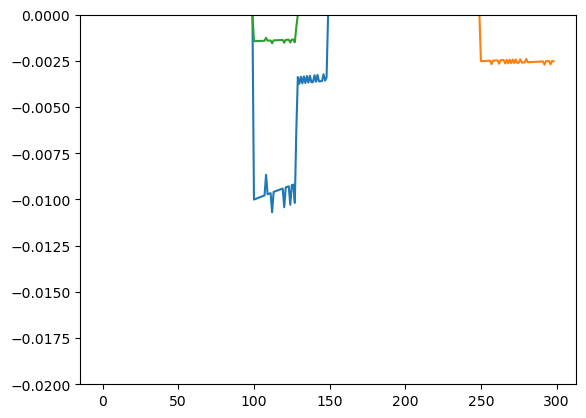

In [ ]:
# plt.plot(np.real(work_al) / (works[0] + works[1]))
plt.plot(np.real(work_al))
plt.plot(np.real(work_al) - (works[0] + works[1]) * (works_ext[0] + works_ext[1] + 1.12))
plt.plot(works_ext[0] + works_ext[1])
plt.ylim(-0.02, 0.0)

## Efficiency

In [ ]:
import pandas as pd

# Find the real temperatures between which the machine operates
T_hot = s_evolution[0].ptrace(0).tr()
T_hot = config["phaseonium"]["T_hot"]
T_cold = config["phaseonium"]["T_cold"]

print(f"T_hot: {T_hot} - T_cold: {T_cold}")

# Calculate the Carnot efficiency
carnot_efficiency = 1 - (T_cold / T_hot)

# Calculate efficiencies
efficiency_alicki = np.real(total_work_al) / np.real(absorbed_heat)
efficiency_classical = np.real(total_work) / np.real(absorbed_heat)
efficiency_external = np.real(total_work_ext) / np.real(absorbed_heat)

# Create a dataframe
efficiency_data = {
    "Definition": ["Alicki's Work", "Classical Work", "External Work", "Carnot Efficiency"],
    "Efficiency": [efficiency_alicki, efficiency_classical, efficiency_external, carnot_efficiency]
}

efficiency_df = pd.DataFrame(efficiency_data)

# Display the dataframe
print(efficiency_df)

# Save the dataframe to a CSV file
efficiency_df.to_csv(OUTPUT / "efficiency_table.csv", index=False)


T_hot: 2.5 - T_cold: 1.0
          Definition  Efficiency
0      Alicki's Work   -0.019704
1     Classical Work   -0.008254
2      External Work    0.000000
3  Carnot Efficiency    0.600000
